In [1]:
from scipy import integrate
import scipy as sc
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Constantes

In [447]:
# Datos Llantas tractivas 
rll_std=0.139 # Radio geométrico de las llantas en traseras (m)
#refc_std=0.98*rll_std # Radio efectivo llantas traseras (m)
refc_std = 0.1*0.98
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=10.0 # Dientes del piñón
dpl=19.0 # Dientes del plato
#ng_std=dpl/dp # Relación de Transmisión
ng_std = 1.9
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa_std=145.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s2)
w_std=masa_std*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
u_w=0.0 # velocidad del viento (m/s)
theta=0.0 # ángulo inclinación carretera

# Inercias
ii=5.2E-3 # Inercia motor (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll_std)+(mdt*(rll_std**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

# Transmisión
rpi=0.01525 # Radio piñón (m)
rpla=0.04096 # Radio plato (m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñón (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñón (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñón (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

mr_std = ((2*illd + 2*illt)+ieje+(ii*(ng_std**2)))/(refc_std**2) # Masa equivalente de los componentes rotatorios (kg-m^2)

omega_max = 523.6

# Distribución de peso
w_rear = w_std*0.5
w_front = w_std-w_rear

# Fuerza Frenado
mu = 0.7
F_bf = 0*w_front*mu
F_br = 1*w_rear*mu
F_b = F_bf + F_br

T_f = 17 # [Nm]

# Fuerzas Aceleración
# Resistencia a la rodadura
            
a = 0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l = 1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h = 0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

<h1><center>Funciones</center></h1>

## Drag

<h3><center>$D = \frac{1}{2} \rho A_F C_D V^2$</center></h3>

In [448]:
def drag(vx):
    D = (1.0/2.0)*rho*af*cd*(vx)**2 # (N)
    return D

## Resistencia a la rodadura

<h3><center>$ Rx = W \cdot fr \cdot cos(\theta)$</center></h3>
<h3><center>$ fr = 0.01\cdot(1+\frac{3.6 V_x}{100.0})$</center></h3>

In [449]:
def roll_resist (vx,w=w_std):
    fr=0.01*(1+((vx*3.6)/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    Rx = w*fr*cos(theta) # (N)
    
    # wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas -> incluir aceleración (weight shift)
    # Rx = wr*fr*cos(theta)
    
    return Rx

## Velocidad angular del motor

In [450]:
def omega_motor(vx,refc=refc_std,ng=ng_std):
    
    omega = (vx*ng)/(refc) # (rad/s)
    
    if omega >= omega_max: 
        omega = omega_max
        
    return omega

In [451]:
def vel_max(refc=refc_std,ng=ng_std):

    v_max = omega_max*refc/ng
    
    return v_max

## Torque Motor

In [452]:
def torque_motor (vx):
    
    omega = omega_motor(vx)
        
    RPM = omega*(60/(2*np.pi))

    Power = ((-0.00000004564538677*(RPM**3))+(0.0001056995459*(RPM**2))+(1.53209191*RPM)-12.96)
    
    Torque = Power/(RPM*2.0*np.pi/60)
    
    if RPM <= 20:
        Torque = 2
    
    return Torque #Nm

## Power Motor

In [453]:
def power_motor (vx):
    
    omega = omega_motor(vx)
     
    RPM = omega*(60/(2*np.pi))

    Power = ((-0.00000004564538677*(RPM**3))+(0.0001056995459*(RPM**2))+(1.53209191*RPM)-12.96)
    
    #Power = torque_motor(vx)*(RPM*2.0*np.pi/60)
    
    return Power #W

## Aceleración

<h1><center>$a_x = \frac{\frac{T_e N_c \eta_t}{r} - R_x - D_A - Wsin\theta}{(M+M_r)}$</center></h1>

In [454]:
def accel (vx,refc=refc_std,ng=ng_std,masa=masa_std, mr=mr_std):   
        
    ax = (((torque_motor(vx)*ng*etaf)/refc) - roll_resist(vx) - drag(vx) - (masa*g)*sin(theta))/(masa+mr)
    
    if ax <= 1e-6:
        ax = 0
        
    if vx >= vel_max(refc,ng):
        ax = 0
               
    return ax

In [455]:
def dvdt_a(y, t,refc=refc_std,ng=ng_std,masa=masa_std,mr=mr_std):
    xx, vx = y
    
    T = (torque_motor(vx)*ng*etaf)/refc
    Rx = roll_resist(vx)
    D = drag(vx)
    W_i = (masa*g)*sin(theta)
    
    ax = (T-Rx-D-W_i)/(masa+mr)
    
    if ax <= 1e-6:
        ax = 0
    
    if vx >= vel_max(refc,ng):
        ax = 0
    
    dydt = [vx, ax]
    return dydt

## Frenado

<h1><center>$a_x = \frac{-F_b - R_x - D_A - Wsin\theta}{(M+M_r)}$</center></h1>

In [456]:
def braking (vx,refc=refc_std,ng=ng_std,masa=masa_std,mr=mr_std):        
    ax_b = (-((T_f*ng*etaf)/refc) - roll_resist(vx) -drag(vx) - (masa*g)*sin(theta))/(masa+mr)    
    
    if vx <= 1e-5:
        vx = 0
        ax_b = 0
    
    return ax_b

In [457]:
def dvdt_b(y, t,refc=refc_std,ng=ng_std,masa=masa_std,mr=mr_std):
    xx, vx = y
    
    T = (T_f*ng*etaf)/refc
    Rx = roll_resist(vx)
    D = drag(vx)
    W_i = (masa*g)*sin(theta)
    
    ax = (-T-Rx-D-W_i)/(masa+mr)
    
    if vx <= 1e-5:
        vx = 0
        ax = 0
    
    dydt = [vx, ax]
    return dydt

# Performance

In [458]:
# Variables de tiempo
t_in=0
t_fin=140
deltat=0.001

# condiciones iniciales
x_0=0
v_0=0.001
c_ini = [x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

In [459]:
# Resolver para velocidad con aceleración 
sol_a = integrate.odeint(dvdt_a, c_ini, t)

In [460]:
pos_a = sol_a[:, 0]
vel_a = sol_a[:, 1]

In [461]:
# Variables de tiempo
t_in_b=t_fin
t_fin_b=t_in_b+25

# condiciones iniciales
c_ini_b = [pos_a[-1],vel_a[-1]]
t_b=np.arange(t_in_b,t_fin_b,deltat)

In [462]:
# Resolver para velocidad con frenado
sol_b = integrate.odeint(dvdt_b, c_ini_b, t_b)

In [463]:
pos_b = sol_b[:, 0]
vel_b = sol_b[:, 1]

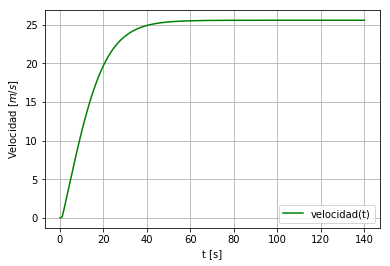

In [464]:
ax = plt.gca()

ax.plot(t, vel_a, 'g', label='velocidad(t)')
#ax.plot(t_b, vel_b, 'b', label='velocidad(t)')
ax.set_xlabel('t [s]')
ax.set_ylabel('Velocidad [$m/s$]')
ax.grid()
plt.legend(loc = 'best')

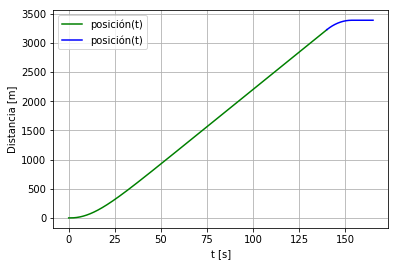

In [465]:
ax2 = plt.gca()

ax2.plot(t, pos_a, 'g', label='posición(t)')
ax2.plot(t_b, pos_b, 'b', label='posición(t)')
ax2.set_xlabel('t [s]')
ax2.set_ylabel('Distancia [m]')
ax2.grid()
plt.legend(loc = 'best')

In [466]:
vel_a.max()

25.593520754532083

In [467]:
tor = []
rx = []
D = []
tot = []

for i in range(len(vel_a)):

    tau = ((torque_motor(vel_a[i])*ng_std*etaf)/refc_std)
    res = roll_resist(vel_a[i])
    dr = drag(vel_a[i])
    
    tor.append(tau)
    rx.append(res)
    D.append(dr)
    tot.append(res+dr)

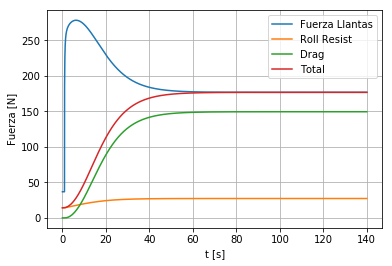

In [468]:
ax3 = plt.gca()

ax3.plot(t, tor, label='Fuerza Llantas')
ax3.plot(t, rx, label='Roll Resist')
ax3.plot(t, D, label='Drag')
ax3.plot(t, tot, label='Total')
ax3.set_xlabel('t [s]')
ax3.set_ylabel('Fuerza [N]')
ax3.grid()
plt.legend(loc = 'best')

In [469]:
vel_max()

27.006736842105266